In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')
from vega_datasets import data

import pymc3 as pm
import arviz as az

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


Bad key "text.kerning_factor" on line 4 in
C:\Users\ruote\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution
C:\Users\ruote\Anaconda3\lib\site-packages\dask\config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.19.0

sklearn   : 0.23.2
seaborn   : 0.11.0
numpy     : 1.15.4
pymc3     : 3.9.3
arviz     : 0.10.0
matplotlib: 3.1.2
pandas    : 1.1.0



### Data

In [3]:
iris = sns.load_dataset('iris')
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


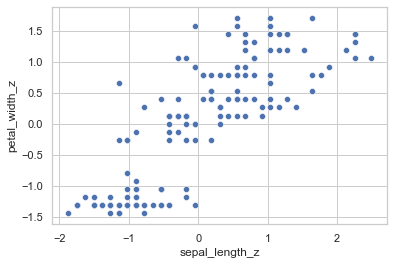

In [4]:
iris[['sepal_length_z','petal_width_z']] = StandardScaler().fit_transform(iris[['sepal_length','petal_width']])

sns.scatterplot(data=iris, x='sepal_length_z', y='petal_width_z')

### PyMC3 Model

In [5]:
# lifesaver for making predictions on new data
def model_factory(x, y):
    with pm.Model() as model:
        # data
        x = pm.Data('x', x)
        y = pm.Data('y', y)

        # priors on parameters
        α = pm.Normal('α', 0, 1)
        β = pm.Normal('β', 0, 1)
        σ = pm.HalfNormal('σ', 1)

        # model
        μ = pm.Deterministic('μ', β * x + α) # unnecessary and probably inefficient - using this just for 'prettier' graph
        y_hat = pm.Normal('y_hat', mu=μ, sigma=σ, observed=y)
    return model

In [6]:
model = model_factory(iris['sepal_length_z'], iris['petal_width_z'])

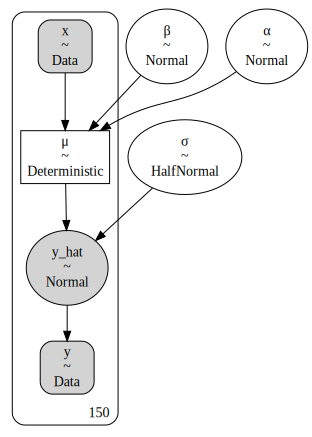

In [7]:
pm.model_to_graphviz(model)

In [8]:
with model:
    # Prior sampling, trace definition and posterior sampling
    prior = pm.sample_prior_predictive()
    posterior = pm.sample()
    posterior_pred = pm.sample_posterior_predictive(posterior)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


In [9]:
inf_obj = az.from_pymc3(prior=prior, trace=posterior, posterior_predictive=posterior_pred,
                        model=model)
az.to_netcdf(inf_obj, 'model_11.netcdf')
inf_obj

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [6]:
inf_obj = az.from_netcdf('model_11.netcdf')
inf_obj

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

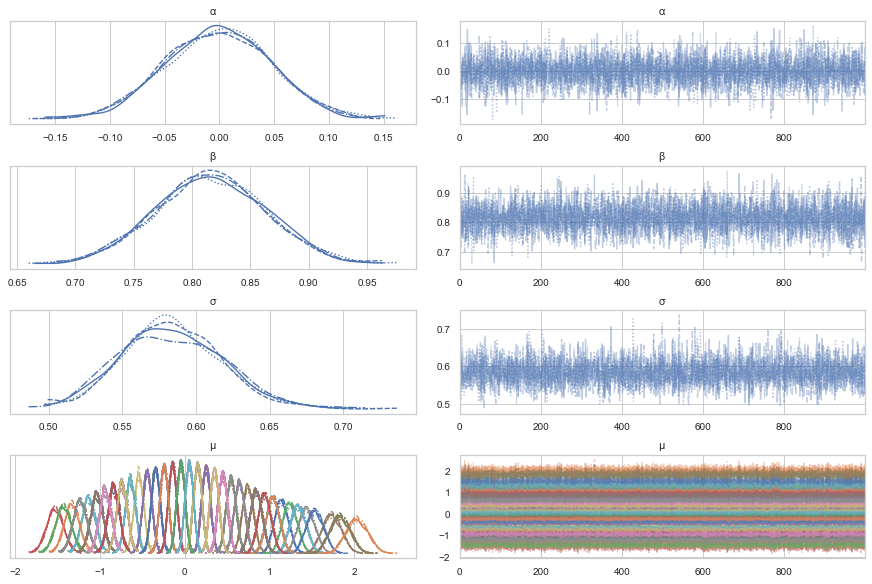

In [10]:
pm.traceplot(inf_obj);

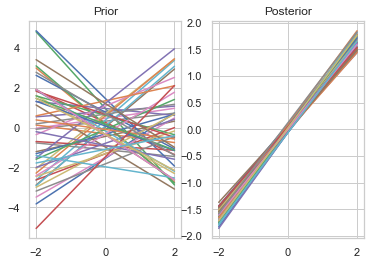

In [10]:
nshow = 50

samples = 500 # default n_samples in pymc3
idx = np.random.randint(0, samples, nshow)

fig, (ax1,ax2) = plt.subplots(ncols=2)
for α, β in zip(inf_obj.prior.get('α').values.flatten()[idx], 
                inf_obj.prior.get('β').values.flatten()[idx]):
    xs = np.linspace(-2, 2)
    ax1.plot(xs, β * xs + α)
ax1.set(title='Prior');

samples = 4000 # default n_samples in pymc3
idx = np.random.randint(0, samples, nshow)

for α, β in zip(inf_obj.posterior.get('α').values.flatten()[idx], 
                inf_obj.posterior.get('β').values.flatten()[idx]):
    xs = np.linspace(-2, 2)
    ax2.plot(xs, β * xs + α)
ax2.set(title='Posterior');

### sklearn Model

In [11]:
clf = LinearRegression()
clf.fit(iris[['sepal_length_z']], iris['petal_width_z'])

LinearRegression()

### Analysis and comparison

In [13]:
map_est = pm.find_MAP(model=model)

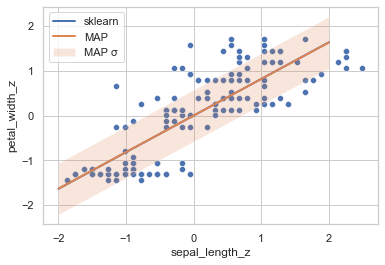

In [14]:
fig, ax = plt.subplots()

sns.scatterplot(data=iris, x='sepal_length_z', y='petal_width_z', ax=ax)

xs = np.linspace(-2, 2)
ax.plot(xs, clf.predict(xs[:,np.newaxis]), linewidth=2, label='sklearn')

ax.plot(xs, map_est['β'] * xs + map_est['α'], linewidth=2, label='MAP')
ax.fill_between(xs, 
                map_est['β'] * xs + map_est['α'] + map_est['σ'], 
                map_est['β'] * xs + map_est['α'] - map_est['σ'], 
                alpha=0.2, label='MAP σ')

ax.legend()

In [15]:
with model_factory(xs, np.zeros_like(xs)) as model_test:
    # use training trace to generate posterior samples on test set
    new_preds = pm.sample_posterior_predictive(posterior)

C:\Users\ruote\Anaconda3\lib\site-packages\arviz\stats\stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


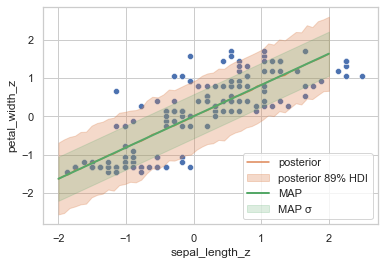

In [18]:
fig, ax = plt.subplots()

sns.scatterplot(data=iris, x='sepal_length_z', y='petal_width_z', ax=ax)

hdi = az.hdi(new_preds['y_hat'], hdi_prob=0.89)
ax.fill_between(xs, hdi[:,0], hdi[:,1], alpha=0.3, color='C1', label='posterior 89% HDI')
ax.plot(xs, new_preds['y_hat'].mean(axis=0), color='C1', label='posterior')

ax.fill_between(xs, 
                map_est['β'] * xs + map_est['α'] + map_est['σ'], 
                map_est['β'] * xs + map_est['α'] - map_est['σ'], 
                alpha=0.2, color='C2', label='MAP σ')
ax.plot(xs, map_est['β'] * xs + map_est['α'], linewidth=2, color='C2', label='MAP')

ax.legend();
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[0], handles[2], handles[1], handles[3]], [labels[0], labels[2], labels[1], labels[3]]);